In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, recall_score, accuracy_score, precision_score
from sklearn.tree import plot_tree

In [2]:
data_path = "/content/drive/MyDrive/Colab Notebooks/Data/address_data_combined.csv"

In [3]:
df_combine = pd.read_csv(data_path)

In [4]:
print(df_combine.shape)
print(df_combine.head())
f_txn = len(df_combine[df_combine['FLAG'] == 1])
print('current amount of fraud is now ', f_txn, ' which is ', (f_txn/len(df_combine))*100, ' % of the original dataset')

(19787, 29)
                                      Address  Avg min between sent tnx  \
0  0x6c96769a08ddefa92e06de0a32089272c57f79b2                 32.464093   
1  0x73f858acd93866902f59a8b53ab5f8ae1824c74b                 32.079906   
2  0x8dab36ee57328e700380d1fd6588bc3de5fe8ec3                 32.210966   
3  0xc9c736bab11d24528c3543b14e610e5c6a30d921                 57.475760   
4  0xd74e2d68510786311f05a898ea6fa7a36727ee55                 32.476325   

   Avg min between received tnx  Time Diff between first and last (Mins)  \
0                           0.0                                173455.65   
1                           0.0                                173456.05   
2                           0.0                                173456.05   
3                           0.0                                417906.25   
4                           0.0                                173456.05   

   Sent tnx  Received Tnx  Number of Created Contracts  Number of Tnx Error  \
0

In [5]:
df_combine.nunique()

Address                                                  19783
Avg min between sent tnx                                 13726
Avg min between received tnx                             13344
Time Diff between first and last (Mins)                  16344
Sent tnx                                                  2071
Received Tnx                                               973
Number of Created Contracts                                 30
Number of Tnx Error                                        577
Unique Received From Addresses                             420
Unique Sent To Addresses                                   968
min value received                                        9286
max value received                                       11481
avg val received                                         13675
min val sent                                              6449
max val sent                                             12200
avg val sent                                           

In [6]:
# First performing random forest
print('Random forest can only classify numerical columns, hence further processing needs to be done')
df_combine_forest = df_combine.select_dtypes(include='number')
print(df_combine_forest.shape)
print('3 columns have been dropped')

Random forest can only classify numerical columns, hence further processing needs to be done
(19787, 28)
3 columns have been dropped


In [7]:
x = df_combine_forest.drop('FLAG',axis=1)
print(x.shape)
y = df_combine_forest['FLAG'] # y_column needs to be 1d
print(y.shape)

(19787, 27)
(19787,)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(x,y,train_size=0.7,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13850, 27), (5937, 27), (13850,), (5937,))

In [9]:
# Hyperparameter tuning for random forest using gridsearchcv to fit the data

rf = RandomForestClassifier(random_state=42,n_jobs=-1)

params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

In [10]:
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv=4,
                           n_jobs=-1,
                           verbose=1,
                           scoring="f1")

In [11]:
grid_search.fit(X_train,y_train)

Fitting 4 folds for each of 180 candidates, totalling 720 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 30, 50, 100, 200]},
             scoring='f1', verbose=1)

In [12]:
print(grid_search.best_score_)
rf_best = grid_search.best_estimator_
print(rf_best)

0.9634067193184945
RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_estimators=200,
                       n_jobs=-1, random_state=42)


In [13]:
rf = RandomForestClassifier(max_depth=20,min_samples_leaf=5,n_estimators=50,n_jobs=-1,random_state=42)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
print(f1_score(y_test,y_pred))
print(roc_auc_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred))

0.9648940897644793
0.9594688228655998
0.963894643385617
0.9600808489135927
0.9658956109134045


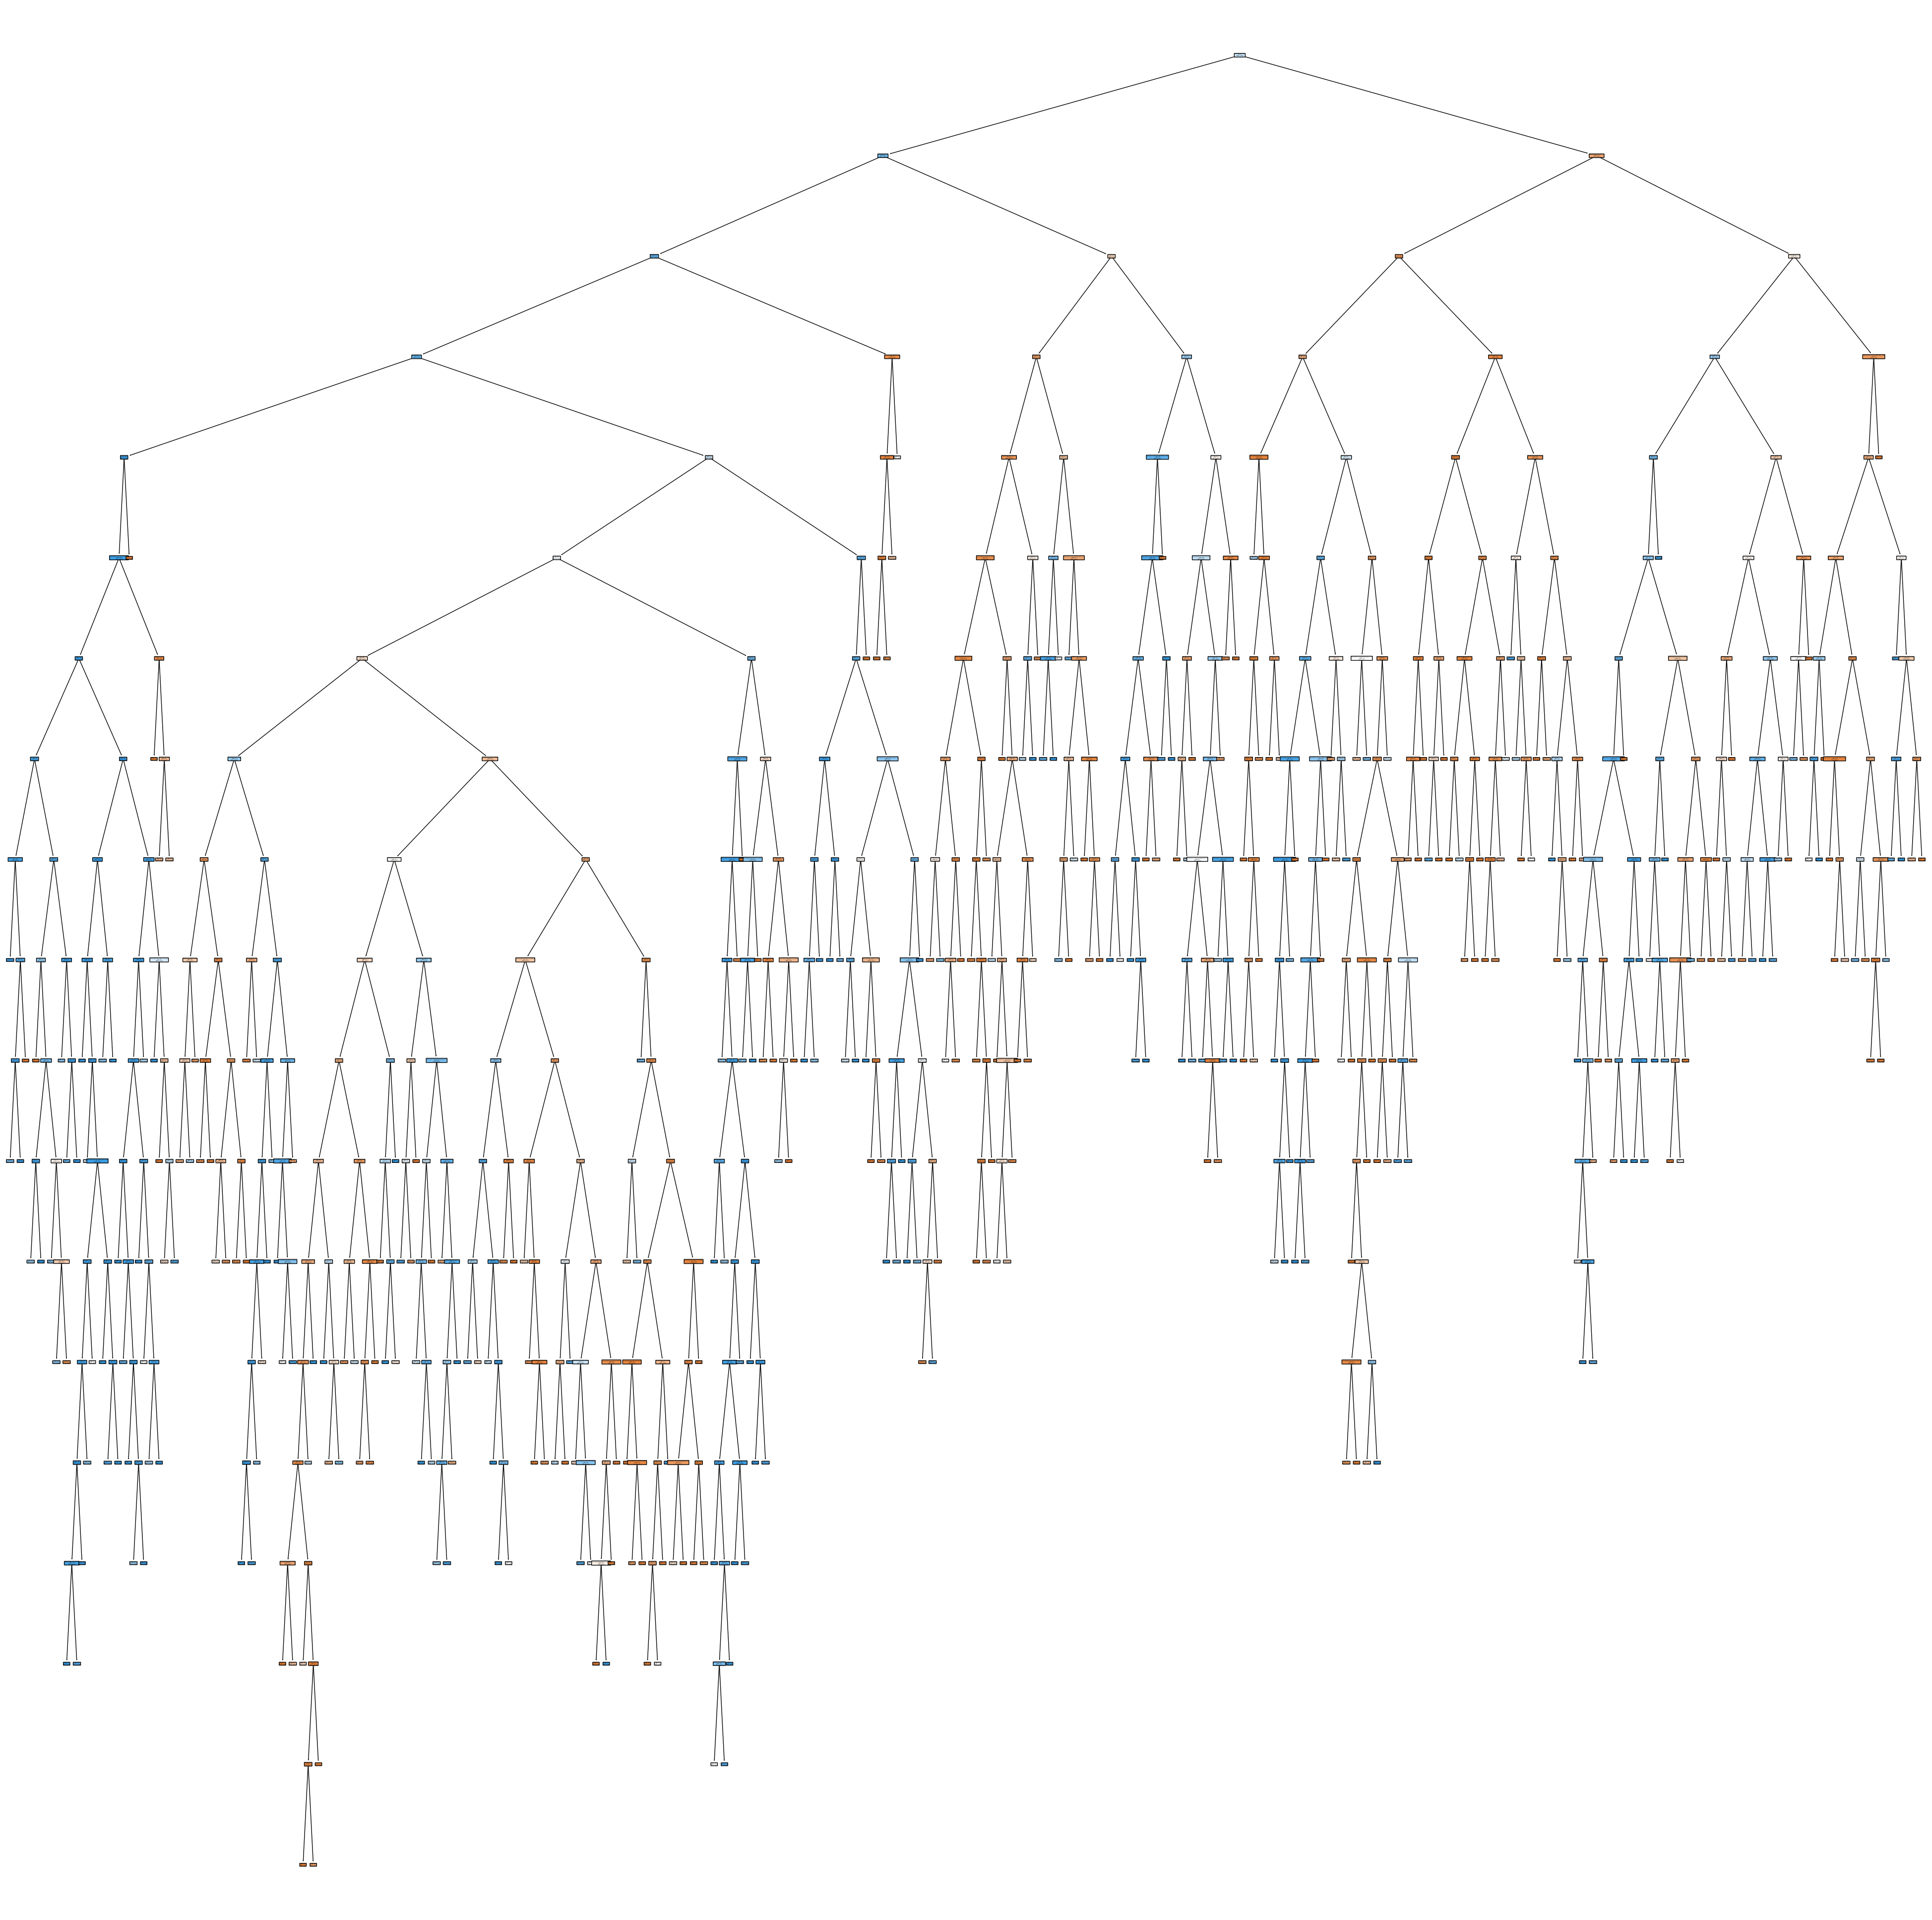

In [14]:
plt.figure(figsize=(50,50))
plot_tree(rf_best.estimators_[5], feature_names = x.columns,class_names=['Fraud', "No Fraud"],filled=True,proportion=True,rounded=True,precision=2)
plt.savefig("tree.eps")

In [15]:
rf_best.feature_importances_

array([0.0420807 , 0.02068652, 0.0943403 , 0.02936843, 0.02106496,
       0.00735823, 0.01155103, 0.01756527, 0.00939414, 0.03914649,
       0.06206328, 0.08161861, 0.01974424, 0.02212719, 0.03777221,
       0.        , 0.        , 0.        , 0.07110938, 0.02601368,
       0.02711809, 0.03732627, 0.0258176 , 0.10670359, 0.02667754,
       0.        , 0.16335227])

In [16]:
feature_imp_df = pd.DataFrame({
    "Features" : X_train.columns,
    "Importance" : rf_best.feature_importances_
})
feature_imp_df.sort_values(by="Importance",ascending=False)

,Features,Importance
26,total ether balance,0.163352
23,total ether received,0.106704
2,Time Diff between first and last (Mins),0.094340
11,avg val received,0.081619
18,min gas fee,0.071109
10,max value received,0.062063
0,Avg min between sent tnx,0.042081
9,min value received,0.039146
14,avg val sent,0.037772
21,total transactions (including tnx to create co...,0.037326


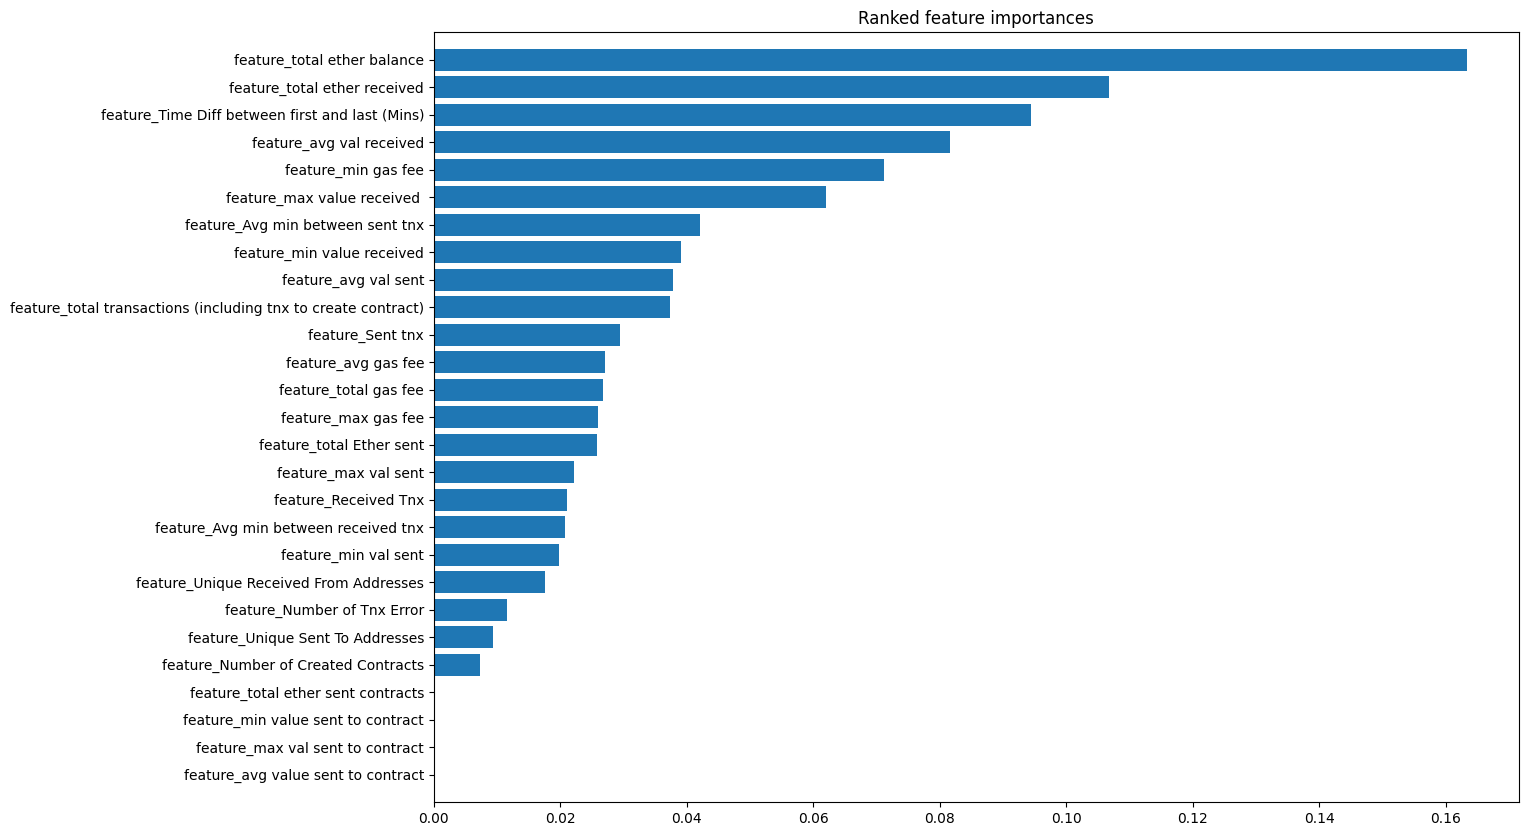

In [17]:
feat_importances = rf_best.feature_importances_
indices = np.argsort(feat_importances)
# plot
columns = np.array(X_train.columns)
fig, ax = plt.subplots(figsize=(14, 10))
plt.title("Ranked feature importances")
plt.barh(range(len(feat_importances)), feat_importances[indices], align="center")
features = ['feature_{}'.format(columns[i]) for i in range(len(columns))]
plt.yticks(range(len(feat_importances)), [features[idx] for idx in indices])
plt.ylim([-1, len(feat_importances)])
plt.show()